# Text Information Extraction - Sequences - Exercise: Bi-Gram Language Model

## Table of Contents

* [Introduction](#Introduction)
  * [Required Knowledge](#Required-Knowledge)
  * [Required Python Modules](#Required-Python-Modules)
  * [Required Data](#Required-Data)


* [Markov Models](#Markov-Models)
  * [Markov Assumption](#Markov-Assumption)
  * [Markov Chains](#Markov-Chains)
* [Language Models](#Language-Models)
* [Pen-and-Paper Exercises](#Pen-and-Paper-Exercises)
  * [Exercise: Terminology](#Exercise%3A-Terminology)
  * [Exercise: Language Models](#Exercise%3A-Language-Models)
* [Programming Exercises](#Programming-Exercises)
  * [Exercise: Normalization](#Exercise%3A-Normalization)
  * [Exercise: Allowed Terms](#Exercise%3A-Allowed-Terms)
  * [Exercise: Count Bi-Grams](#Exercise%3A-Count-Bi-Grams)
  * [Exercise: Sentence-Probability](#Exercise%3A-Sentence-Probability)
  * [Exercise: Sampling](#Exercise%3A-Sampling)
  * [Exercise: Laplace Smoothing](#Exercise%3A-Laplace-Smoothing)
  * [Exercise: Perplexity](#Exercise%3A-Perplexity)


* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

This notebook introduces Markov Models as a way to represent Bi-Gram language models. It is advised, but not strictly required, to learn about Bayesian Networks first. Studying Bayesian Networks provides you with a basic understanding of probability theory and graphical models, which is useful in this context.

The comprehensive exercises in this notebook will guide you through the steps of implementing a Bi-Gram language model. Due to the general data sparsity in the Natural Language Processing (NLP) domain, the implementation requires various adaptions concerning numerical stability, which will be addressed accordingly.

As a data source, the ABC text corpus provided by [Natural Language Toolkit (nltk)](https://www.nltk.org/) is used.

### Required Knowledge

* Basics of Probability Theory, e.g. 

 * Khan Academy [Statistics and probability](https://www.khanacademy.org/math/statistics-probability).
 * Kurze Übersicht [Wahrscheinlichkeitstheorie](http://christianherta.de/lehre/dataScience/basics/Wahrscheinlichkeitstheorie.php)
* Bayesian Networks (Optional), e.g.:
    * [Bayesian Networks](http://christianherta.de/lehre/dataScience/bayesian_networks/Bayessche_Netze_Repraesentation.html) 
    * [Bayesian Networks by Example](https://gitlab.com/deep.TEACHING/educational-materials/blob/master/notebooks/machine-learning-fundamentals/probability-theory/bayesian-networks-by-example.ipynb)

### Required Python Modules

In [ ]:
# Python Standard Library
from collections import Counter

# External Modules
import numpy as np
from numpy.testing import assert_almost_equal
import nltk

### Required Data

In [ ]:
nltk.download('abc')
nltk.download('punkt')
sequences = nltk.corpus.abc.sents()

In [ ]:
# the first two sentences of the data set
print(sequences[0:2])

## Markov Models

In one of the preliminary notebooks _Bayesian Networks by Example_, we have introduced graphical models. Each node in a Bayesian Network corresponds to a random variable, which can take on different values with a certain probability given the predecessors of the variable.

A Markov Model is very similar, but represents a sequence of states. For example $W_1, ..., W_n$ could represent a temporal sequence of weather states, where $W_1, ..., W_n$ are random variables.

Possible values of $W$ are defined as

$$
Val(W) = \{Sunny, Cloudy, Rainy\}.
$$

For example, the following graphical representation shows a sequence of weather states for five days.

Usually, we observe a specific sequence of events, for example $W_1 = Sunny, W_2 = Sunny, W_3 = Cloudy, W_4 = Rainy$.

### Markov Assumption



Now we make the assumption that the probability of a state depends only on the previous state.
This means that $W_5$ becomes independent of $W_1$, $W_2$ and $W_3$ given $W_4$:

$$
(W_5 \perp W_1, W_2, W_3 )\mid W_4 
$$

e.g. the last term of calculating $P(S)$ is now by the Markov assumption:

$$P(W_5 \mid W_4 , W_3 , W_2 , W_1 ) = P(W_5 \mid W_4)$$ 

So we have for the probability for the sequence $S$:

$$
\begin{align}
 P(S) =  P(W_1, W_2, W_3, W_4,  W_5) &=
 P(W_1) \cdot P(W_2 \mid W_1) \cdot P(W_3 \mid W_2) \cdot P(W_4 \mid W_3) \cdot P(W_5 \mid W_4) 
\end{align}
$$

The Markov Chain as directed graphical model (Bayesian Network):

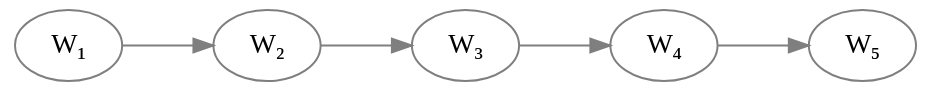


From the graph we can deduce the markov assumption at each time step.

In general, so the probability of a Markov sequence $S$ is
$$
p(S) = p(W_1) \prod_{t=2}^n P(W_t \mid W_{t-1})
$$

### Transition Probabilities

We can now predict the next observed state in a sequence, by just looking at the current state. 

Assume, that we already know all transition probabilities from each possible state to the next state, we can express them in a matrix for the transition probabilities
$P(W_t\mid W_{t-1})$ as follows.

$$
\begin{bmatrix}
p(Sunny\mid Sunny) & p(Cloudy\mid Sunny) & p(Rainy\mid Sunny) \\
p(Sunny\mid Cloudy) & p(Cloudy\mid Cloudy) & p(Rainy\mid Cloudy) \\
p(Sunny\mid Rainy) & p(Cloudy\mid Rainy) & p(Rainy\mid Rainy) \\
\end{bmatrix} = 
\begin{bmatrix}
0.8 & 0.15 & 0.05 \\
0.2 & 0.5 & 0.3 \\
0.2 & 0.2 & 0.6 \\
\end{bmatrix} 
$$

If it is $Sunny$ at a given point in a sequence, the probability that it will be $Cloudy$ afterwards can be expressed as $P(W_t = Cloudy \mid W_{t-1} = Sunny)$. 

In [ ]:
index = {
    'Sunny': 0,
    'Cloudy': 1,
    'Rainy': 2
}

W = np.array([
    [0.8, 0.15, 0.05],
    [0.2, 0.5, 0.3],
    [0.2, 0.2, 0.6]
])

The value of $P(W_t = Cloudy \mid W_{t-1} = Sunny)$ can be accessed in the probability table $W$ as follows.

In [ ]:
W[index['Sunny'], index['Cloudy']]

#### State transition graphs

The transition probabilities can also be illustrated by state transitions graphs as follows:

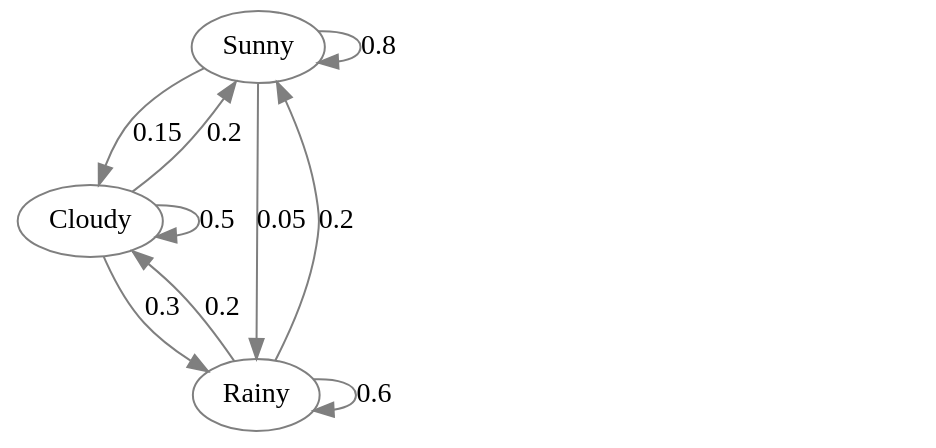

The edges between nodes represent the transition probability from state to another, as shown in the example below.

Note: The state transition graph is not a probabilistical graphical model.

#### Markov Processes

A _Markov process_ consists of
- a set of states 
- a transition (probability) matrix

Such a Markov process can generate a Markov chain, a sequence of random variables.

## Application: Language Models

Markov Models can be used as language models. Here we consider only Bi-Grams. In practice, 
higher n-Grams language models are used which are quite similar.

A language model maps each sequence of terms (states) to a probability. The probability of the sentence in the language.
Typically such a language model is learnt from a training corpus.

Consider the following sentence `s`, which is contained in the ABC text corpus. The sentence is a sequence of terms.

In [ ]:
s = sequences[12215]
print(s)

Prepending a `START` tag and appending an `END` tag allows us to assign probabilities to a term being at the beginning or the end of sentence respectively.

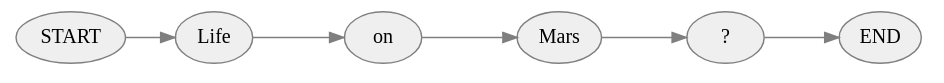

In [ ]:
sse = ['START'] + s + ['END']
print(sse)

Bi-Grams are all possible combinations of two subsequent words in the sentence. See the following code, for a list of all Bi-Grams in `sse`.

In [ ]:
list(zip(sse[:-1], sse[1:]))

In order to estimate probabilities for all possible terms and their successors (transition probabilities), we have to count all Bi-Grams in the training corpus. Since the number of possible terms in a text corpus is large, the resulting transition matrix requires a lot of memory and is sparse. A sparse matrix has a lot of $0$-entries, i.e. here transition probabilities equal zero.

In [ ]:
raw_terms = set()

for sentence in sequences:
    raw_terms.update(sentence)

len(raw_terms)

## Pen-and-Paper Exercises



The exercises in this notebook will we prepare you and 
guide through the implementation of a language model.
<!-- and how to apply some tricks to reduce sparsity.-->


### Exercise: Terminology

What is the difference between *Word*, *Token*, *Type* and *Term*?

To answer the question, read the beginning of [2.2.1. Tokenization](https://nlp.stanford.edu/IR-book/pdf/02voc.pdf) of "Introduction to information retrieval" [[SCH08](#SCH08)].
<!-- Word: A delimited string of characters as it appears in the text.
Term: A normalized word (case, morphology, spelling etc); an equivalence class of words.
Token: An instance of a word or term occurring in a document.
Type: The same as a term in most cases: an equivalence class of tokens.
-->

### Exercise: Language Models

Study the fundamentals of N-Gram language models in [Chapter 3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) "Language Modeling with N-Grams" (accessed online 16.12.2018) of ["Speech and Language Processing"](https://web.stanford.edu/~jurafsky/slp3/) [[JUR18](#JUR18)].

 
Further Readings: [Language Modeling (Lecture Notes for NLP)](http://www.cs.columbia.edu/~mcollins/lm-spring2013.pdf) [[COL13](#COL13)], accessed online 05.04.2018
 

Solve the following exercises in [Chapter 3](https://web.stanford.edu/~jurafsky/slp3/3.pdf)  [[JUR18](#JUR18)] (see pp. 25 in the linked PDF). The exercises 3.1-3.5 are strongly recommended. 


## Programming Exercises

### Exercise: Normalization

Write a python function which normalizes the corpus as follows:

* convert all uppercase letters to lower case
* replace all digits by char `#`

In [ ]:
DIGIT = '#'

In [ ]:
# fill in your normalization code in the function body
def normalize(corpus):
    for s in corpus:
        normalized_sentence = None
        raise NotImplementedError()
        yield normalized_sentence

In [ ]:
# a normalised sentence
for i, s in enumerate(normalize(sequences)):
    if i == 3:
        print(s)
        break

In [ ]:
def test_normalize():
    input_corpus = [['R2D2', 'ist', 'ein', 'Roboter', 'aus', 'dem', 'Jahr', '1977', '.']]
    output_corpus = [['r#d#', 'ist', 'ein', 'roboter', 'aus', 'dem', 'jahr', '####', '.']]
    normalized_corpus = list(normalize(input_corpus))
    assert normalized_corpus == output_corpus
    
test_normalize()

### Exercise: Allowed Terms

Create a set of allowed terms. In this case we allow only the 8190 most common terms, to artificially reduce the size of our vocabulary. This is an important step to reduce the memory consumption of our Bi-Gram matrix, which we will construct in a later step.

* Create a Python set, containing only the most common terms.
* Hint: for the initial counting you could use the Counter class from collections.

In [ ]:
NUM_ALLOWED = 8190

In [ ]:
# fill in code to create a list containing allowed terms
allowed_terms = None

In [ ]:
def test_allowed_terms():
    assert isinstance(allowed_terms, set)
    assert 'suggests' in allowed_terms
    assert 'research' in allowed_terms
    assert 'astonishing' not in allowed_terms
    assert len(allowed_terms) == NUM_ALLOWED
    
test_allowed_terms()

The allowed terms are used in an additional filter function `allowed` which is applied as a generator. The filter function will replace every unknown term, not contained in the vocabulary by `UNK`.

In [ ]:
UNKNOWN = 'UNK'

In [ ]:
# we create a function, which filters infrequent terms
def allowed_func(allowed_terms):
    # this is a closure (allowed_terms are stored)
    def allowed(corpus):
        for s in corpus:
            yield [term if term in allowed_terms else UNKNOWN for term in s]
    
    # the returned function will have access to allowed_terms from its definition context
    return allowed

In [ ]:
allowed = allowed_func(allowed_terms)

In [ ]:
# filter infrequent terms from a normalised sentence
for i, s in enumerate(allowed(normalize(sequences))):
    if i == 3:
        print(s)
        break

### Exercise: Index

Now that we have reduced the allowed vocabulary to a certain number of terms $N$, we can build an index. This index does not only include each $TERM$, but also special symbols $UNK$ and $START\_END$. We can use $START\_END$ as a shared index for $START$ and $END$, because $START$ can only be on the left side of a Bi-Gram and $END$ can only be on the right side of a Bi-Gram. [Exercise: Count Bi-Grams](#Exercise%3A-Count-Bi-Grams) will explain this in detail.

* Create Python dictionary `index` where terms and special symbols are keys, while assigned values are integers.

In [ ]:
START_END = 'START_END'

In [ ]:
# fill in code to create a dictionary containing a term index
index = dict()
# e.g. index['research'] has index 8045

In [ ]:
len(index)

In [ ]:
index['research']

In [ ]:
def test_index():
    assert isinstance(index, dict)
    assert len(index) == len(allowed_terms) + 2
    assert UNKNOWN in index
    assert START_END in index
    
    for key, val in index.items():
        assert isinstance(key, str)
        assert isinstance(val, int)
    
    assert list(sorted(index.values())) == list(range(len(allowed_terms) + 2))
    
test_index()

### Exercise: Count Bi-Grams

In this exercise you will create a numpy matrix, which stores the number of occurrences of each Bi-Gram from our training corpus. We can think of a Bi-Gram as a combination of two subsequent elements $a$ and $b$, where $a$ can be $START$, $UNK$ or a $TERM$ and where $b$ can be $END$, $UNK$ or a $TERM$. We can store a count for each possible combination of $a$ and $b$ in a matrix, by assigning the first dimension to $a$ and the second dimension to $b$.

The `index`, which lets us map $a$ or $b$ to a fixed position in the array, has already been defined. For $START$ we only need a row, but no column, while for $END$ we only need a column, but not row. Therefore the shared index $START\_END$ is a useful trick.

* Initialize a numpy array $C$, which stores Bi-Gram counts $ab$ for all combinations of $a$ and $b$.
  * Use the first dimension (rows) for $a$ and the second dimension (columns) for $b$.
* For lower memory consumption, use the numpy datatype ([dtype](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.dtypes.html)) `np.uint16`, instead of `np.int64`.
* Fill the array with Bi-Gram counts from the training corpus.
  * Use the dict `index` to refer to the correct indices in the matrix.
  * START $\rightarrow$ END is a valid Bi-Gram for empty sequences.

In [ ]:
# fill in code to initialize numpy data structures and fill them with bi-gram counts
C = None

for s in allowed(normalize(sequences)):
    pass

In [ ]:
C[index['research'], index['suggests']]

In [ ]:
def test_C():
    assert C.shape == (len(index), len(index))
    assert C.dtype == np.uint16
    assert C[index[START_END], index[START_END]] == 0
    
test_C()

### Exercise: Bi-Gram Probability

Implement a function `p(a, b)`, which returns the probability $P(b \mid a)$ for a given Bi-Gram $a$, $b$. The probability of a Bi-Gram, is defined as

$$
\begin{align}
P(a, b) &= \frac{C(a, b)}{\sum\limits_{v\in V} C(a, v)}
\end{align}
$$

where $V$ is the vocabulary (the terms $v$ in `index`).
$|V|$ is the size of the vocabulary, including the `START_END` tag, 
and where $C(a,b)$ is the Bi-Gram count of $ab$. 

* `p(a, b)` must have access to `C` and the `index`.
  * Hint: You can use a closure as demonstrated in [Exercise: Allowed Terms](#Exercise%3A-Allowed-Terms).
* Raise exception if `a == END`.
* Raise exception if `b == START`.

In [ ]:
START = 'START'
END = 'END'

In [ ]:
# fill in code to implement a closure p_func, which returns p
def p_func(C, index):
    raise NotImplementedError()
    # variables which are defined here, will be available in p
    
    def p(a, b):
        pass
    
    return p

In [ ]:
p = p_func(C, index)

In [ ]:
p('research', 'suggests')

In [ ]:
def test_probability(p):
    test_terms = set(allowed_terms)
    test_terms.update([UNKNOWN, END])
    
    assert_almost_equal(sum(p(START, term) for term in test_terms), 1.0)
    assert_almost_equal(sum(p(UNKNOWN, term) for term in test_terms), 1.0)
    assert_almost_equal(sum(p('research', term) for term in test_terms), 1.0)
    assert_almost_equal(sum(p('suggests', term) for term in test_terms), 1.0)
    
    def exception_raised(a, b):
        raised = False
        try:
            p(a, b)
        except:
            raised = True

        return raised
    
    assert exception_raised(END, UNKNOWN)
    assert exception_raised(UNKNOWN, START)

test_probability(p)

### Exercise: Sentence Probability


The probability of a sentece $S$ is by the product of the probabilities of all Bi-Grams in the sequence:

$$
P(S) =  P(v_0) \prod_{t=1}^{n} P(v_t \mid v_{t-1}) = \prod_{t=1}^{n} P(v_t \mid v_{t-1})
$$

* $v_0$ refers to `START` ($P(v_0)=1$)
* $v_n$ refers to `END`
* $n$ is the length of the sentence


First implement a function `sentence_probability(s, p)` which calculates the probability $P(S)$.

* Parameter `s` is a sentence, without `START` or `END` tags.
* Parameter `p` takes a function to calculate Bi-Gram probabilities, for example `p(a, b)`.


The multipication of small numbers can result in numerical instabilities. So it's numerically more stable to add logarithms of the probabilities.

Recall: adding in logarithmic space is equivalent to multiplying without logarithms (see example below), but prevents numerical instabilities due to floating-point arithmetic.

$$
log(P(v_1 \mid START) \cdot P(v_2 \mid v_1) \cdot P(END \mid v_2)) = log(P(v_1 \mid START)) + log(P(
v_2 \mid v_1)) + log(P(END \mid v_2))
$$


You should also implement a second function `sentence_log_probability(s, p)`, which calculates the probability of a full sentence $P(S)$, by adding the logarithmic probabilites of all Bi-Grams in sentence.

$$
\log P(S) =   \sum_{t=1}^{n} \log P(v_t \mid v_{t-1}) 
$$


Hint: Use [np.log](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).



In [ ]:
# fill in code to implement a function which return a sequence probabiliy
def sentence_probability(s, p):
    raise NotImplementedError()
    
def sentence_log_probability(s, p):
    raise NotImplementedError()

In [ ]:
s1 = ['research', 'suggests', '.']
s2 = ['research', 'data', '.']

In [ ]:
sentence_probability(s1, p), sentence_probability(s2, p)

In [ ]:
sentence_log_probability(s1, p), sentence_log_probability(s2, p)

In [ ]:
np.log(sentence_probability(s1, p)), sentence_log_probability(s1, p)

In [ ]:
def test_sentence_probability(p):
    for s in allowed(normalize(sequences)):
        break
    
    assert_almost_equal(np.log(sentence_probability(s, p)), sentence_log_probability(s, p))
    
test_sentence_probability(p)

### Exercise: Sampling

Implement a function `sample(max_length=50)`, which returns a random sentence generated from the model.

* `sample(max_length=50)` must have access to `C` and the `index`.
  * Use a closure as demonstrated in [Exercise: Allowed Terms](#Exercise%3A-Allowed-Terms).
* You can use [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to draw from a random distribution of the model.
* Sampled sentences should not include `START` or `END` tags.
* Remember to use `START` Bi-Grams to determine the probabilities of possible sentence beginnings.
* Return a sentence as soon as an `END` tag has been sampled or if `max_length` is reached.

In [ ]:
# fill in code to implement a closure sample_func, which returns sample
def sample_func(C, index):
    raise NotImplementedError()
    # variables which are defined here, will be available in sample
    
    def sample(max_length=50):
        pass
    
    return sample

In [ ]:
sample = sample_func(C, index)

In [ ]:
for _ in range(2):
    print(' '.join(sample()))

### Exercise: Laplace Smoothing

When we want to assign a probability to a new sentence (not in the training set), it can be possible that it contains Bi-Grams with estimated transition probability zero. So the probability of the sentence under the model would be zero.
A remedy for this is smoothing.

Implement a function `p_laplace(a, b)`, which returns the probability $\hat{P}(b \mid a)$ for a given Bi-Gram $a$, $b$ with Laplace smoothing applied. Laplacing smoothing, also known as Add-One smoothing, is defined as



$$
\begin{align}
\hat{P}(a, b) &= \frac{C(a, b) + 1}{\sum\limits_{v\in V} (C(a, v) + 1)} \\
           &= \frac{C(a, b) + 1}{\sum\limits_{v\in V} C(a, v) + |V|}
\end{align}
$$

where $|V|$ is the size of the vocabilary (`index`), including the `START_END` tag, and where $C$ is the Bi-Gram count.

* `p_laplace(a, b)` must have access to `C` and the `index`.
  * Use a closure as demonstrated in [Exercise: Allowed Terms](#Exercise%3A-Allowed-Terms).
* The implementation is similar to the existing function `p(a, b)` and must pass the same tests.
* Raise exception if `a == END`.
* Raise exception if `b == START`.

In [ ]:
# fill in code to implement a closure p_laplace_func, which returns p_laplace
def p_laplace_func(C, index):
    raise NotImplementedError()
    # variables which are defined here, will be available in sample
    
    def p_laplace(a, b):
        pass
    
    return p_laplace

In [ ]:
p_laplace = p_laplace_func(C, index)

In [ ]:
p_laplace('research', 'suggests'), p('research', 'suggests')

We can use `p_laplace` as replacement for `p` in our existing functions.

In [ ]:
sentence_log_probability(s1, p), sentence_log_probability(s1, p_laplace)

We can also use `p_laplace` in our existing tests.

In [ ]:
test_probability(p_laplace)

In [ ]:
test_sentence_probability(p_laplace)

### Exercise: Perplexity

Implement a function `perplexity(corpus)`, which returns the perplexity score of the model on a complete test corpus. Perplexity is defined as

$$
\begin{align}
Perplexity(T) &= \sqrt[N]{ \frac{1}{\prod\limits_{S \in T} P(S)} } \\
&= \left(\frac{1}{\prod\limits_{S \in T} P(S)}\right)^{\frac{1}{N}} \\
&= exp\left(log\left(\left(\frac{1}{\prod\limits_{S \in T} P(S)}\right)^{\frac{1}{N}}\right)\right) \\
&= exp\left(\frac{1}{N} \cdot log\left(\frac{1}{\prod\limits_{S \in T} P(S)}\right)\right) \\
&= exp\left(\frac{1}{N} \cdot \left(log(1) - log\left(\prod\limits_{S \in T} P(S)\right)\right)\right) \\
&= exp\left(-\frac{1}{N} \cdot log\left(\prod\limits_{S \in T} P(S)\right)\right) \\
&= exp\left(-\frac{1}{N} \cdot \sum\limits_{S \in T} log\left(P(S)\right)\right)
\end{align}
$$

where $T$ is a test corpus and $N$ is the number of all Bi-Grams in the corpus. The formula above gives you a clean mathematical definition at the top, and a numerically stable conversion using logarithmic probabilities at the bottom. For more intuition on perplexity watch [Nlp - 2.3 - Evaluation and Perplexity](https://www.youtube.com/watch?v=BAN3NB_SNHY) by Daniel Jurafsky.

* Use the numerically stable formula at the bottom as a reference for your implementation.
* Use your exiting functions `sentence_log_probabilities` and `p_laplace` for Bi-Gram probabilities.
* Use [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html).

In [ ]:
# use a test corpus, instead of the training corpus
for s in allowed(normalize(sequences)):
    break
print(s)

In [ ]:
# fill in your perplexity code in the function body
def perplexity(corpus):
    # your code goes here
    raise NotImplementedError()

In [ ]:
# Here we compute the perplexity on our training corpus. 
# But for comparing the quality of different language models
# a separate test corpus would be necessary.

perplexity(allowed(normalize(sequences)))

## Summary and Outlook

You have learned about Markov Models and how to implement a language model. With your acquired knowledge you can move on to Hidden Markov Models and apply them to tagging problems like [Named Entity Recognition](../../../text-information-extraction.md).

## Literature

<table>
    <tr>
        <td>
            <a name="SCH08"></a>[SCH08]
        </td>
        <td>
            Schütze, Hinrich, Christopher D. Manning, and Prabhakar Raghavan. "Introduction to information retrieval". Vol. 39. Cambridge University Press, 2008
        </td>
    </tr>
    <tr>
        <td>
            <a name="JUR18"></a>[JUR18]
        </td>
        <td>
            Daniel Jurafsky, James H. Martin. "Speech and Language Processing", Chapter 3: Language Modeling with N-Grams. 3rd ed. draft n.p. Draft of Sep 23, 2018 published at <a href='https://web.stanford.edu/~jurafsky/slp3/'>https://web.stanford.edu/~jurafsky/slp3/</a> [accessed Dec 16 2018]
        </td>
    </tr>
    <tr>
        <td>
            <a name="COL13"></a>[COL13]
        </td>
        <td>
            Michael Collins. "Course notes for NLP", Columbia University, 2013
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g. images).*

Text Information Extraction - Sequences - Exercise: Bi-Gram Language Model<br/>
by [Christoph Jansen](https://www.htw-berlin.de/hochschule/personen/person/?eid=9225) and [Christian Herta](https://www.htw-berlin.de/hochschule/personen/person/?eid=2605) (deep.TEACHING - HTW Berlin)<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christoph Jansen, Christian Herta

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.